# Classification -- Images & Hands-On

## Table of Contents
<ol>
    <li>Processing of complicated data like images</li>
    <li>Thinking about models to use for image classification</li>
    <li>Implementation of common models</li>
    <li>Convolutional neural networks -- an ML greatest hit</li>
</ol>

## 1. Processing of complicated data like images

#### Suppose we begin with colored 32 x 32 pixel images of objects we wish to classify.

![](cifar.png)
<span style="font-size:0.75em;">CIFAR-10 Krizhevsky et al.</span>

### How can we encode the information from one image?
![](corgis.png)
![](doge.png)
<span style="font-size:0.75em;">commonlounge.com; subsubroutine.com</span>

### Let's start with a simpler example

In [1]:
import keras
import tensorflow as tf
print(keras.__version__)
print(tf.__version__)

Using TensorFlow backend.


2.2.4
1.13.1


<class 'numpy.ndarray'>
(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


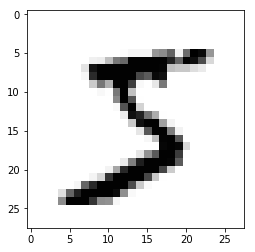

In [2]:
from keras.datasets import mnist
import sklearn
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

(X, y), (X_test, y_test) = mnist.load_data()

print(type(X))
print(X.shape, y.shape)
print(X_test.shape, y_test.shape)

plt.imshow(X[0], cmap="Greys")

255


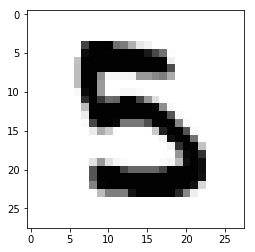

In [3]:
plt.imshow(X[20125], cmap="Greys")
print(np.max(X_test))

### As long as each data point is of the same shape, we can unroll these 2- or 3-tensors into long vectors
- How many dimensions in each CIFAR-10 data point? Remember this number.

In [4]:
# Flatten each X
X = X.reshape(X.shape[0], X.shape[1]*X.shape[2])
print(X.shape)

(60000, 784)


### Our classification output will be a vector of 0s except for the target class, which should be a 1.
### Presently our output is instead encoded as a single ordinal variable between 0 and 9.

In [5]:
# Encode each element of y as 10-length "one-hot vector" with binary elements
y_ord = y

y = keras.utils.to_categorical(y)
print(y.shape)
print(y[0])

(60000, 10)
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


### Lastly, let's choose an error metric

In [6]:
def score(true, pred):
    acc = 0
    for i in range(len(true)):
        if np.sum(np.dot(true[i], pred[i])) == 1.0:
            acc += 1
    score = acc / len(true)
    return score

## 2. Thinking about models to use for image classification

### k-Nearest neighbors

* 1-Nearest Neighbors (aka nearest neighbors)
    - Use some distance metric to compare each 784-D vector to all others
    - Order samples by distance
    - Classify the same as the smallest distance example
* k-Nearest Neighbors
    - Classify by committee based on several small distances
* Where do these fail?
* How do these scale with training examples?

### Logistic regression
* Optimal parameters attained from maximizing the likelihood of dataset, aka minimizing the negative log-likelihood
$$\mathcal{L}(\theta = \{W,b\},\mathcal{D}) = \sum_{i=0}^{|\mathcal{D}|} log(P(Y = y^{(i)} | x^{(i)},W,b))$$
![](log_reg.png)
* "nonlinear" -- though always depends directly on weighted sums of pixels

### Random forest classifiers
* "Split" predictions based on pixels or collection of pixels
* Truly nonlinear

### Feed-forward neural networks
* Nonlinear
* Permits "communication" between pixels via dense layers

## 3. Implementation of common models
### WAIT what haven't I done yet?

In [7]:
# Train val split before model choosing
X_train = X[:54000]
y_train = y[:54000]
y_ord_train = y_ord[:54000]

X_val = X[54000:]
y_val = y[54000:]
y_ord_val = y_ord[54000:]

### k-Nearest Neighbors

In [8]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)
preds = model.predict(X_val[:100])
print(score(y_val[:100], preds))

0.97


### Logistic regression

In [9]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='saga', tol=0.01, n_jobs=4, verbose=1)

model.fit(X_train, y_ord_train)
preds = model.predict(X_val)

/usr/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 41 epochs took 20 seconds
convergence after 41 epochs took 20 seconds
convergence after 44 epochs took 22 seconds
convergence after 53 epochs took 29 seconds
convergence after 45 epochs took 31 seconds
convergence after 48 epochs took 34 seconds
convergence after 54 epochs took 37 seconds
convergence after 47 epochs took 31 seconds
convergence after 45 epochs took 23 seconds
convergence after 53 epochs took 27 seconds


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:  1.3min finished


In [10]:
# Create equivalent accuracy score for ordinal outputs
def score_ord(true, preds):
    acc = 0
    for i in range(len(true)):
        if true[i] == preds[i]:
            acc += 1
    score = acc / len(true)
    return score

In [11]:
print(score_ord(y_ord_val,preds))

0.931


### Random forest classifiers

In [12]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_val)
print(score(y_val, preds))

/usr/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.8836666666666667


### Feed-forward neural networks

In [13]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(hidden_layer_sizes=(100,50,20))
model.fit(X_train, y_train)
preds = model.predict(X_val)
print(score(y_val, preds))

0.9708333333333333


## 4. Convolutional neural networks

![](conv_net.png)
<span style="font-size:0.75em;">easy-tensorflow.com</span>


* A <i>filter</i> might be a square $k \times k$ matrix of weights.
* A single <i>filter</i> traverses an image, elementwise multiplying pixels in its range, adding, and performing a nonlinearity.
* The new <i>feature map</i> generated is typically the same size or smaller than the input.
* Many <i>feature maps</i> are generated with different <i>filters</i>, each with different weights
* <i>Pooling layers</i> serve to reduce feature map dimensionality.
* The CNN concludes with generic Dense layers

### Examines local areas of photographs -- takes full photo matrix as input, not flattened

In [14]:
(X, y), (X_test, y_test) = mnist.load_data()
y_train = keras.utils.to_categorical(y)
y_test = keras.utils.to_categorical(y_test)

### Suppose I have validated the following hyperparameters such that I believe they are optimal. <i>Now</i> we can test.

In [15]:
X_train = X.reshape(60000,28,28,1)
# Additional 1 rank to indicate greyscale for special layers

X_test = X_test.reshape(10000,28,28,1)

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, BatchNormalization, Dropout, Flatten

model = Sequential()

model.add(Conv2D(32,kernel_size=3,activation='relu',input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(Conv2D(32,kernel_size=3,activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32,kernel_size=5,strides=2,padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(64,kernel_size=3,activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64,kernel_size=3,activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64,kernel_size=5,strides=2,padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

history = model.fit(X_train, y_train, batch_size=128, epochs=25, verbose=1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/25
60000/60000 [==============================] - 227s 4ms/step - loss: 0.2564 - acc: 0.9220
Epoch 2/25
60000/60000 [==============================] - 230s 4ms/step - loss: 0.0658 - acc: 0.9803
Epoch 3/25
60000/60000 [==============================] - 231s 4ms/step - loss: 0.0503 - acc: 0.9848
Epoch 4/25
60000/60000 [==============================] - 230s 4ms/step - loss: 0.0414 - acc: 0.9872
Epoch 5/25
60000/60000 [==============================] - 230s 4ms/step - loss: 0.0352 - acc: 0.9890
Epoch 6/25
60000/60000 [==============================] - 231s 4ms/step - loss: 0.0328 - acc: 0.9900
Epoch 7/25
60000/60000 [==============================] - 231s 4ms/step - loss: 0.0276 - acc: 0.9916
Epoch 8/25
60000/60000 [==============================] - 

![](KaggleMNIST.png)
<span style="font-size:0.75em;">Kaggle - Chris Deotte 2018</span>

In [22]:
preds = model.predict(X_test)
final = np.zeros_like(preds)
final[np.arange(len(preds)), preds.argmax(1)] = 1

print(score(y_test, final))

0.9953


In [23]:
model.save("nice_cnn.h5")

### A word on inductive bias and domain knowledge
* CNNs take advantage of our understanding of local features in mapping images to semantic meaning (number labels, dog/cat/plane)
* "A universal function approximator": The infinitely large dense NN can fit any analytic function exactly with enough data.
    - "Not really": We rarely have "enough data" and can't train infinitely large NNs
    - The name of the game is making the network size and data requirements <i>practical</i>
* The state of the art usually comes from understanding your problem first